<a href="https://colab.research.google.com/github/RaquelHernanz/Projects_II_HeartDataset/blob/master/Dataset_PCA_FeatureSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries, import and configuration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    f_classif,
    mutual_info_classif,
    RFE,
    SequentialFeatureSelector
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

pd.set_option("display.max_columns", None)

In [ ]:
heart_dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/heart.csv")
pd.set_option("display.max_columns", None)

In [ ]:
X = heart_dataset.drop(columns=["target"])
y = heart_dataset["target"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Form de X_scaled:", X_scaled.shape)

# Comprobar que todo es numérico (PCA lo exige)
print(X.dtypes)

Form de X_scaled: (1025, 13)
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
dtype: object


# 1. Principal Component Analysis (PCA)

**Purpose:** Principal Component Analysis (PCA) is applied to the standardized heart-disease dataset to explore its latent structure, assess redundancy among predictors, and evaluate whether meaningful dimensionality reduction is feasible without supervised information.

- *Standardization prior to PCA:*
All features are standardized to zero mean and unit variance to ensure that PCA captures correlation structure rather than differences in measurement scale.

- *Variance-based exploration:*
The explained variance ratio and cumulative variance are analyzed to quantify how much information is captured by successive components and to determine the number of components required to retain 90–95% of total variance.

- *Low-dimensional visualization:*
Projection onto the first two principal components (PC1–PC2) provides an interpretable, unsupervised view of patient separation and global data structure.

- *Loading analysis and biplot:*
Component loadings are examined to identify which clinical variables drive each principal component and to interpret PCs in terms of physiological axes.

## **Results after applying PCA**

PCA was applied to the standardized heart-disease dataset to summarize its multidimensional structure and identify dominant clinical patterns. Although the dataset contains 13 numeric predictors, the variance is relatively dispersed: PC1 explains ~21% of the variance and PC1–PC2 together account for ~33%. Nevertheless, PC1 captures a clear ischemia-severity axis strongly associated with heart-disease presence, driven by variables such as ST-depression (oldpeak), exercise-induced angina (exang), reduced maximum heart rate (thalach), number of affected vessels (ca), and age. PC2 represents a metabolic-demographic axis involving blood pressure, cholesterol, fasting blood sugar, sex, and age. While PCA does not provide major dimensionality reduction without substantial information loss (requiring 11–12 PCs to retain 90–95% variance), the projection onto the first two components offers a meaningful low-dimensional view and reveals a strong unsupervised separation between healthy and diseased patients.

In [ ]:
pca = PCA()          # sin n_components: calcula todas
X_pca = pca.fit_transform(X_scaled)

expl_var = pca.explained_variance_ratio_
cum_expl_var = np.cumsum(expl_var)

print("Explained variance ratio by component:")
for i, (ev, cev) in enumerate(zip(expl_var, cum_expl_var), start=1):
    print(f"PC{i:2d}: {ev:6.3f}  (cumulative: {cev:6.3f})")

Explained variance ratio by component:
PC 1:  0.214  (cumulative:  0.214)
PC 2:  0.120  (cumulative:  0.333)
PC 3:  0.092  (cumulative:  0.426)
PC 4:  0.090  (cumulative:  0.516)
PC 5:  0.077  (cumulative:  0.593)
PC 6:  0.075  (cumulative:  0.667)
PC 7:  0.067  (cumulative:  0.735)
PC 8:  0.059  (cumulative:  0.794)
PC 9:  0.056  (cumulative:  0.850)
PC10:  0.048  (cumulative:  0.898)
PC11:  0.040  (cumulative:  0.938)
PC12:  0.033  (cumulative:  0.972)
PC13:  0.028  (cumulative:  1.000)


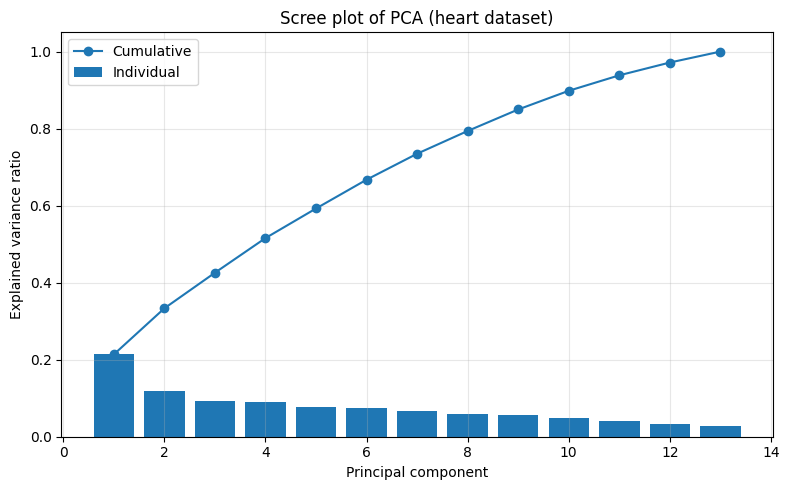

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(range(1, len(expl_var)+1), expl_var, label="Individual")
plt.plot(range(1, len(expl_var)+1), cum_expl_var, marker="o", label="Cumulative")
plt.xlabel("Principal component")
plt.ylabel("Explained variance ratio")
plt.title("Scree plot of PCA (heart dataset)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Choose number of components for 90–95% variance
for threshold in [0.90, 0.95]:
    n_comp = np.argmax(cum_expl_var >= threshold) + 1
    print(f"With {n_comp} components you explain at least {threshold*100:.0f}% of the variance.")

With 11 components you explain at least 90% of the variance.
With 12 components you explain at least 95% of the variance.


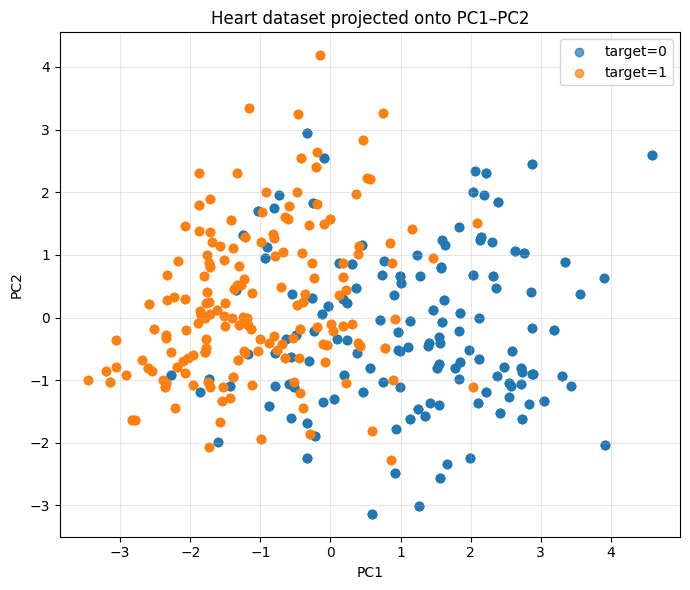

In [ ]:
pc1 = X_pca[:, 0]
pc2 = X_pca[:, 1]

plt.figure(figsize=(7,6))
for cls in sorted(y.unique()):
    mask = (y == cls)
    plt.scatter(pc1[mask], pc2[mask], alpha=0.7, label=f"target={cls}")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Heart dataset projected onto PC1–PC2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=[f"PC{i}" for i in range(1, len(X.columns)+1)]
)

print("Variables with highest absolute loadings on PC1:")
display(loadings["PC1"].sort_values(key=lambda s: s.abs(), ascending=False))

print("\nVariables with highest absolute loadings on PC2:")
display(loadings["PC2"].sort_values(key=lambda s: s.abs(), ascending=False))

Variables with highest absolute loadings on PC1:


,PC1
oldpeak,0.421781
thalach,-0.416970
slope,-0.380108
exang,0.363869
age,0.309574
cp,-0.285616
ca,0.265334
thal,0.214070
trestbps,0.178760
restecg,-0.129490



Variables with highest absolute loadings on PC2:


,PC2
trestbps,0.438909
age,0.398286
sex,-0.379076
chol,0.369819
fbs,0.321476
cp,0.274947
exang,-0.258613
restecg,-0.244760
thal,-0.182619
ca,0.105858


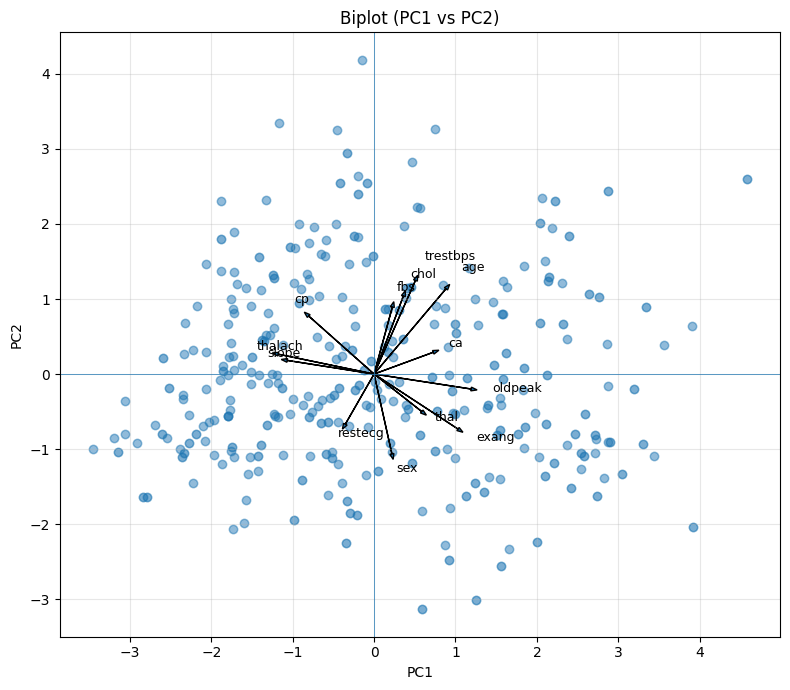

In [ ]:
plt.figure(figsize=(8,7))
plt.scatter(pc1, pc2, alpha=0.2)

# Scale vectors so they are visible
scale = 3
for var in X.columns:
    plt.arrow(
        0, 0,
        loadings.loc[var, "PC1"] * scale,
        loadings.loc[var, "PC2"] * scale,
        head_width=0.05,
        length_includes_head=True
    )
    plt.text(
        loadings.loc[var, "PC1"] * scale * 1.15,
        loadings.loc[var, "PC2"] * scale * 1.15,
        var,
        fontsize=9
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Biplot (PC1 vs PC2)")
plt.grid(True, alpha=0.3)
plt.axhline(0, linewidth=0.5)
plt.axvline(0, linewidth=0.5)
plt.tight_layout()
plt.show()

# 2. Featuare Selection

## Filter methods

**Purpose:**
Filter-based feature selection methods are used to evaluate the univariate relevance, redundancy, and statistical association of predictors with the target variable, independently of any specific predictive model.

- *Variance Threshold:*
Low-variance filtering verifies whether any features lack sufficient variability to contribute meaningful information.

- *ANOVA F-test:*
The F-statistic quantifies linear association between each feature and the target, highlighting variables with strong discriminative power.

- *Mutual Information:*
Mutual information captures both linear and non-linear dependencies between features and the outcome, complementing ANOVA results.

- *Correlation-based filtering:*
Highly correlated predictors are identified to assess multicollinearity and potential redundancy.

### **Results after applying filter methods**

Filter-based feature selection methods (Variance Threshold, ANOVA F-test, Mutual Information, and correlation filtering) consistently highlighted a core group of informative predictors. Features such as oldpeak, thalach, cp, ca, thal, and exang showed strong univariate association with the presence of heart disease. In contrast, variables like fbs and restecg displayed minimal statistical relevance across all filter criteria. No features were removed due to low variance or high multicollinearity, indicating that the dataset is structurally well-behaved. Overall, the filter methods identified a stable subset of physiologically meaningful features aligned with established clinical markers.

In [ ]:
# -------------------------------------------------
# Filter method 1: Variance Threshold
# -------------------------------------------------
var_selector = VarianceThreshold(threshold=0.01)
var_selector.fit(X_scaled)

low_variance_features = X.columns[var_selector.get_support()]
print("Features kept after VarianceThreshold:")
print(list(low_variance_features))

Features kept after VarianceThreshold:
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


In [ ]:
# -------------------------------------------------
# Filter method 2: ANOVA F-test (SelectKBest)
# -------------------------------------------------
f_selector = SelectKBest(score_func=f_classif, k="all")
f_selector.fit(X_scaled, y)

f_scores = pd.DataFrame({
    "feature": X.columns,
    "F_score": f_selector.scores_
}).sort_values("F_score", ascending=False)

print("ANOVA F-test scores:")
print(f_scores)

ANOVA F-test scores:
     feature     F_score
9    oldpeak  243.450780
8      exang  242.883889
2         cp  238.558457
7    thalach  222.799538
11        ca  174.877078
10     slope  138.679393
12      thal  131.802996
1        sex   86.689707
0        age   56.785135
3   trestbps   20.087353
6    restecg   18.838205
4       chol   10.326152
5        fbs    1.736352


In [ ]:
# -------------------------------------------------
# Filter method 3: Mutual Information
# -------------------------------------------------
mi_scores = mutual_info_classif(X_scaled, y, random_state=42)

mi_df = pd.DataFrame({
    "feature": X.columns,
    "Mutual_Info": mi_scores
}).sort_values("Mutual_Info", ascending=False)

print("Mutual Information scores:")
print(mi_df)

Mutual Information scores:
     feature  Mutual_Info
4       chol     0.275314
7    thalach     0.147683
12      thal     0.136632
2         cp     0.135838
9    oldpeak     0.132645
11        ca     0.120577
8      exang     0.094175
3   trestbps     0.077058
0        age     0.051214
10     slope     0.050117
1        sex     0.032968
6    restecg     0.000515
5        fbs     0.000000


In [ ]:
# -------------------------------------------------
# Filter method 4: Correlation-based filtering
# -------------------------------------------------
corr_matrix = pd.DataFrame(X_scaled, columns=X.columns).corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

high_corr = [
    column for column in upper.columns
    if any(upper[column] > 0.90)   # threshold can be tuned
]

print("Highly correlated features to drop:")
print(high_corr)

X_corr_filtered = X.drop(columns=high_corr)
print("Remaining features after correlation filter:")
print(list(X_corr_filtered.columns))

Highly correlated features to drop:
[]
Remaining features after correlation filter:
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


## Wrapper methods

**Purpose:**
Wrapper-based feature selection methods are employed to identify subsets of features that optimize predictive performance with respect to specific classification models.

- *Recursive Feature Elimination (RFE):*
RFE with Logistic Regression selects features that contribute most strongly to a linear decision boundary.

 - *Sequential Feature Selector (SFS):*
Forward selection with Random Forest identifies features that improve performance in a non-linear, interaction-aware model, optimized using ROC–AUC.

- *Model-dependent comparison:*
Differences between RFE and SFS selections highlight how feature importance depends on the underlying learning algorithm.

### **Results after applying wrapper methods**
Wrapper methods produced partially different selections because they optimize feature subsets with respect to a specific predictive model. RFE with Logistic Regression selected features that contribute strongly in a linear decision boundary, choosing: sex, cp, thalach, oldpeak, ca, and thal. In contrast, the Sequential Feature Selector using Random Forest favored variables that improve non-linear performance and interactions, selecting: age, cp, trestbps, chol, thalach, and oldpeak. Despite methodological differences, both wrappers consistently agreed on cp, thalach, and oldpeak—three of the strongest predictors across the entire analysis.

In [ ]:
# -------------------------------------------------
# Wrapper method 1: RFE with Logistic Regression
# -------------------------------------------------
log_reg = LogisticRegression(max_iter=1000)

# choose how many features you want to keep
n_features = 6

rfe = RFE(estimator=log_reg, n_features_to_select=n_features)
rfe.fit(X_scaled, y)

rfe_selected = X.columns[rfe.get_support()]

print(f"RFE selected {n_features} features:")
print(list(rfe_selected))

RFE selected 6 features:
['sex', 'cp', 'thalach', 'oldpeak', 'ca', 'thal']


In [ ]:
# -------------------------------------------------
# Wrapper method 2: Sequential Feature Selector (SFS)
# -------------------------------------------------
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

# here we ask for, e.g., 6 features as well
sfs = SequentialFeatureSelector(
    rf,
    n_features_to_select=6,
    direction="forward",
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

sfs.fit(X, y)

sfs_selected = X.columns[sfs.get_support()]

print("Sequential Feature Selector (forward) chose:")
print(list(sfs_selected))


Sequential Feature Selector (forward) chose:
['age', 'cp', 'trestbps', 'chol', 'thalach', 'oldpeak']


#**Credits**
## raquel Hernanz Hernández